# Exercise 5 - Variational quantum eigensolver

Simulation of LiH molecule using the STO-3G basis with the PySCF driver and Jordan-Wigner mapping.
We will guide you through the following parts so then you can tackle harder problems.

#### 1. Pass the LiH to a Driver

The interfaces to the classical chemistry codes that are available in Qiskit are called drivers.
We use  `PySCFDriver` for this method we obtain necessary information about our molecule.

By running a driver (Hartree-Fock calculation for a given basis set and molecular geometry), in the cell below, we obtain all the necessary information about our molecule to apply then a quantum algorithm.

In [1]:
from qiskit_nature.drivers import PySCFDriver
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()
print(qmolecule.one_body_integrals)

[[-4.73853724  0.10753914  0.1675853   0.          0.         -0.03026284
   0.          0.          0.          0.          0.          0.        ]
 [ 0.10753914 -1.51317577  0.03434669  0.          0.         -0.06802917
   0.          0.          0.          0.          0.          0.        ]
 [ 0.1675853   0.03434669 -1.12916229  0.          0.          0.03143223
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -1.14077094  0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -1.14077094  0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.03026284 -0.06802917  0.03143223  0.          0.         -0.9418187
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -4.73853724  0.10753914  0.1675853   0.          0.    

In [2]:
n_el = qmolecule.num_alpha + qmolecule.num_beta
n_mo = qmolecule.num_molecular_orbitals
n_so = 2 * qmolecule.num_molecular_orbitals
n_q = 2* qmolecule.num_molecular_orbitals
e_nn = qmolecule.nuclear_repulsion_energy
print("Total number of electrons in the system",n_el)
print("Number of molecular orbitals",n_mo)
print("Number of spin-orbitals",n_so)
print("Number of qubits  you need to simulate this molecule with Jordan-Wigner mapping",n_q)
print("Value of the nuclear repulsion energy",e_nn)

Total number of electrons in the system 4
Number of molecular orbitals 6
Number of spin-orbitals 12
Number of qubits  you need to simulate this molecule with Jordan-Wigner mapping 12
Value of the nuclear repulsion energy 1.0259348796432726


#### 2. Electronic structure

The next step is to use the ElectronicStructureProblem method which returns a list of fermionic. Similarly, we have to reduce or in this case freeze the core orbitals to reduce the number of qubits, this can be done thanks to the FreezeCoreTransformer method and we will remove the orbitals [3,4].

In [3]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit.aqua.operators import Z2Symmetries
from qiskit.chemistry import FermionicOperator

#FreezingCore
problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(remove_orbitals=[3,4])])


# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

/opt/conda/lib/python3.8/site-packages/qiskit/chemistry/__init__.py:170: DeprecationWarning: The package qiskit.chemistry is deprecated. It was moved/refactored to qiskit_nature (pip install qiskit-nature). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('chemistry', 'qiskit_nature', 'qiskit-nature')


#### 3. QubitConverter

Allows to define the mapping that you will use in the simulation. You can try different mapping but 
we will stick to `JordanWignerMapper` as allows a simple correspondence: a qubit represents a spin-orbital in the molecule.

In [4]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper = ParityMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True,z2symmetry_reduction = [1,1])
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)
print(qubit_op)

-0.20316606150558705 * IIII
+ (-0.36525869021603924-1.3877787807814457e-17j) * ZIII
+ 0.09275994933497489 * IZII
- 0.2118898429700879 * ZZII
+ (0.36525869021603924-2.7755575615628914e-17j) * IIZI
- 0.1138433517646434 * ZIZI
+ 0.11395251883046345 * IZZI
+ (-0.060440128573161965+3.469446951953614e-18j) * ZZZI
+ (-0.09275994933497494+3.469446951953614e-18j) * IIIZ
+ 0.11395251883046345 * ZIIZ
- 0.12274244052543896 * IZIZ
+ 0.056288781672179385 * ZZIZ
+ (-0.2118898429700879-1.3877787807814457e-17j) * IIZZ
+ 0.060440128573161965 * ZIZZ
+ (-0.05628878167217939-3.469446951953614e-18j) * IZZZ
+ 0.08460131391823722 * ZZZZ
+ 0.019389408583694687 * XIII
- 0.019389408583694687 * XZII
+ (-0.010952773573810434+8.673617379884035e-19j) * XIZI
+ 0.010952773573810432 * XZZI
+ 0.012779333033028169 * XIIZ
- 0.01277933303302817 * XZIZ
- 0.00900250124383854 * XIZZ
+ 0.00900250124383854 * XZZZ
+ 0.002941141087339334 * IXII
+ 0.0029411410873393337 * ZXII
+ (-0.0106818562829518-8.673617379884035e-19j) * IXZI
-

#### 4. Initial state
We need an initial state, in chemistry a good initial state is the HartreeFock (HF) state (i.e. $|\Psi_{HF} \rangle = |1100 \rangle$). We can initialize it as follows:

In [5]:
from qiskit_nature.circuit.library import HartreeFock
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


#### 5. Ansatz
One of the most important choices is the quantum circuit that you choose to approximate your ground state.
Here is the example of qiskit circuit library that contains many possibilities for making your own circuit.

In [6]:
# Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals



from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ParameterVector
    # Define the variational parameter
theta = ParameterVector('a', length=20)
n = qubit_op.num_qubits
    # Make an empty quantum circuit
qc = QuantumCircuit(qubit_op.num_qubits)
qubit_label = 0
qc.barrier()
for i in range(n):
    qc.ry(theta[i], i)
qc.barrier()

qc.h( range(n))
qc.barrier()
for i in range(n):
    qc.rz(theta[8+i], i)
qc.barrier()
for i in range(n):
    qc.rx(theta[16+i], i)
qc.barrier()
qc.cx(1,0)
qc.barrier()
qc.cx(2,0)
qc.barrier()
qc.cx(3,0)
    
qc.barrier()
for i in range(n):
    qc.rx(theta[16+i], i).inverse()
qc.barrier()
for i in range(n):
    qc.rz(theta[8+i], i).inverse()
qc.barrier() 
qc.h( range(n))
qc.barrier()
qc.barrier()

for i in range(n):
    qc.ry(theta[i],  i).inverse()
qc.barrier()    

# Visual separator
qc.barrier()
ansatz = qc
ansatz.compose(init_state, front=True, inplace=True)

print(ansatz)


     ┌───┐ ░ ┌──────────┐ ░ ┌───┐ ░  ┌──────────┐ ░ ┌───────────┐ ░ ┌───┐ ░ »
q_0: ┤ X ├─░─┤ RY(a[0]) ├─░─┤ H ├─░──┤ RZ(a[8]) ├─░─┤ RX(a[16]) ├─░─┤ X ├─░─»
     ├───┤ ░ ├──────────┤ ░ ├───┤ ░  ├──────────┤ ░ ├───────────┤ ░ └─┬─┘ ░ »
q_1: ┤ X ├─░─┤ RY(a[1]) ├─░─┤ H ├─░──┤ RZ(a[9]) ├─░─┤ RX(a[17]) ├─░───■───░─»
     └───┘ ░ ├──────────┤ ░ ├───┤ ░ ┌┴──────────┤ ░ ├───────────┤ ░       ░ »
q_2: ──────░─┤ RY(a[2]) ├─░─┤ H ├─░─┤ RZ(a[10]) ├─░─┤ RX(a[18]) ├─░───────░─»
           ░ ├──────────┤ ░ ├───┤ ░ ├───────────┤ ░ ├───────────┤ ░       ░ »
q_3: ──────░─┤ RY(a[3]) ├─░─┤ H ├─░─┤ RZ(a[11]) ├─░─┤ RX(a[19]) ├─░───────░─»
           ░ └──────────┘ ░ └───┘ ░ └───────────┘ ░ └───────────┘ ░       ░ »
«     ┌───┐ ░ ┌───┐ ░ ┌───────────┐ ░  ┌──────────┐ ░ ┌───┐ ░  ░ ┌──────────┐»
«q_0: ┤ X ├─░─┤ X ├─░─┤ RX(a[16]) ├─░──┤ RZ(a[8]) ├─░─┤ H ├─░──░─┤ RY(a[0]) ├»
«     └─┬─┘ ░ └─┬─┘ ░ ├───────────┤ ░  ├──────────┤ ░ ├───┤ ░  ░ ├──────────┤»
«q_1: ──┼───░───┼───░─┤ RX(a[17]) ├─░──┤ RZ(a[9]) ├─░─┤ H ├─░

#### 6. Backend
This is where you specify the simulator or device where you want to run your algorithm.
We will focus on the `statevector_simulator` in this challenge.


In [7]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

#### 7. Optimizer

The optimizer guides the evolution of the parameters of the ansatz so it is very important to investigate the energy convergence as it would define the number of measurements that have to be performed on the QPU.
A clever choice might reduce drastically the number of needed energy evaluations.

In [8]:
from qiskit.algorithms.optimizers import COBYLA
optimizer_type = 'COBYLA'
optimizer = COBYLA(maxiter=20000)

#### 8. Exact eigensolver
For learning purposes, we can solve the problem exactly with the exact diagonalization of the Hamiltonian matrix so we know where to aim with VQE.
Of course, the dimensions of this matrix scale exponentially in the number of molecular orbitals so you can try doing this for a large molecule of your choice and see how slow this becomes. 
For very large systems you would run out of memory trying to store their wavefunctions.

In [9]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

# The targeted electronic energy for H2 is -1.85336 Ha
# Check with your VQE result.

Exact electronic energy -1.088706015734739
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


#### 9. VQE and initial parameters for the ansatz
Now we can import the VQE class and run the algorithm.

In [10]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 4796,
    'eigenstate': array([ 1.41612631e-04+1.68089625e-04j,  1.26044865e-03+1.18314236e-03j,
       -9.63255943e-02-7.96593781e-02j, -7.23764108e-01-6.66827503e-01j,
       -3.07958586e-02-3.04536072e-02j,  3.69635796e-03+4.07445389e-03j,
        2.10410872e-02+1.98230782e-02j, -1.43846834e-03-3.80883906e-03j,
        5.43737618e-05-5.92094305e-05j, -7.22219733e-06+7.20806749e-06j,
       -4.14561370e-05+3.56221113e-05j, -3.92761840e-05-4.30276586e-05j,
        6.96082425e-02+6.39194206e-02j, -8.39283207e-03-8.58160778e-03j,
       -4.72112862e-02-4.18659256e-02j,  5.70257735e-03+5.63174848e-03j]),
    'eigenvalue': -1.086561614912408,
    'optimal_parameters': {   ParameterVectorElement(a[2]): -0.15300653808351788,
                              ParameterVectorElement(a[3]): -1.1408071261028125,
                              ParameterVectorElement(a[8]): -0.013418612806918752,
                              ParameterVe

#### 9. Scoring function 
We need to judge how good are your VQE simulations, your choice of ansatz/optimizer.
For this, we implemented the following simple scoring function:

$$ score = N_{CNOT}$$

where $N_{CNOT}$ is the number of CNOTs. 
But you have to reach the chemical accuracy which is $\delta E_{chem} = 0.004$ Ha $= 4$ mHa, which may be hard to reach depending on the problem. 
You have to reach the accuracy we set in a minimal number of CNOTs to win the challenge. 
The lower the score the better!

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,COBYLA,QuantumCircuit,4,12,NaN,NaN,NaN,NaN,2.144522,True,3
0,COBYLA,QuantumCircuit,4,12,None,None,None,None,2.144401,True,3


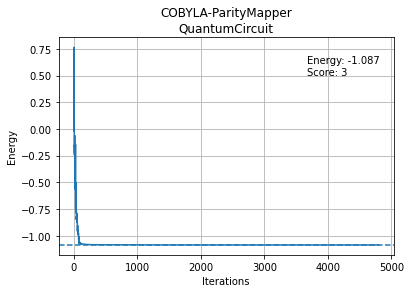

In [11]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
try:
    cnots = ansatz_tp.count_ops()['cx']
except:
    cnots = 0
score = cnots

accuracy_threshold =4.0 # in mHa
energy = result.optimal_value


result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

#### 10. Explanation
For quantum computing, reducing the cost (the number of CNot gates) is very important for this, it is also necessary to reduce the number of initial qubits from 12 to 4, this can be achieved by using the methods FreezeCoreTransformer(remove_orbitals=[3,4]) and QubitConverter(mapper=mapper, two_qubit_reduction=True,z2symmetry_reduction = [1,1]). However, the ansatz proposed for the challenge gave me a higher cost or exceeded the maximum number allowed, 500, so I dedicated myself to design my proposal for 8, 6 and 4 qubits


For this I had to perform many experiments ,in one of those experiments I noticed that q0 is the most important and so each one represents a relevant energy, so I contemplated to make the entanglements with q0 , in addition, I considered the designs of two ansatz https://joshuagoings.com/2020/08/20/VQE/ that occupies the three rotations and the structure that you have in the example of qiskit https://qiskit.org/textbook/ch-applications/vqe-molecules.html#Contents
I decided to make a modification to the qiskit example by changing the cx of qc.cx(i,0) where i ={1,2,3}, because otherwise it always gave the same or lower energy, I also added a layer of rx, which was ry,rz,ry but these had no effect so if I applied the H gate before rz it approached the value and to increase the ratio considering the ansatz of this work https://joshuagoings. com/2020/08/20/VQE/ I saw that they tried to increase with applying inverses after applying the cx so I did the same with each layer of rotation (ry,rz,rx) as in the Hadamard, finally the combination of two schemes were the ones that I based to generate this proposal and using the optimizer COBYLA with 20,000 iteration, because we can reduce the energy with each of this.

For the 8 qubit case I had a cost of 14 because I had to make the block twice, in 6 qubits I had a cost of 10 for the same 8 qubit situation, in the 4 qubit case a cost of 3 6 was obtained but reduced with 1 layer of 3 CNOTs and error of 2.143375 mHa .






#### 11. Solution

We validate the result with the grade for the challenge.

In [12]:
# Check your answer using following code
from qc_grader import grade_ex5
freeze_core = True # change to True if you freezed core electrons
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.



In [13]:
# Submit your answer. You can re-submit at any time.
from qc_grader import submit_ex5
submit_ex5(ansatz,qubit_op,result,freeze_core)

Submitting your answer for ex5. Please wait...
Failed: Error wrong data received.


## Additional information

**Created by:** Igor Sokolov, Junye Huang, Rahul Pratap Singh

**Version:** 1.0.0

## Results

$|𝐸_{𝑒𝑥𝑎𝑐𝑡}−𝐸_{𝑉𝑄𝐸}|<	2.143375$ mHa

**Number of parameters:** 12 

**Score:** 3 CNOTs. 

**Solved by:** Alberto Maldonado Romo (github MaldoAlberto)